## Encoding data to Spikes

Spikes are binary (0 or 1). Most data, like images, videos, and audio isn't. Therefore, we would like a way to *represent* data by "coding" them to spikes -- a proccess known as **spike encoding**.

In this notebook we will 
1. present different encoding methods
2. show how the encoding methods are used in Norse
3. demonstrate how to encode images for use in training
4. discuss project ideas related to encoding 

Please note that **SNNs can work perfectly well *without* spike encoding** (if you remember to normalize).
However, this tutorial discusses spike encoding because it fits with the idea of spikes as the atomic unit of operation in SNNs.
Please also note that the tutorial here only provides a *superficial* treatment of spike encoding.
For further reference see [Wikipedia](https://en.wikipedia.org/wiki/Neural_coding) and [literature on the topic](https://mitpress.mit.edu/books/spikes).

:::{note}
You can execute the notebooks on this website by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::


## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [ ]:
!pip install --quiet norse matplotlib

## 1. Types of encoding

In this tutorial we will discuss three methods for encoding: poisson encoding, spike latency encoding, and population encoding.
Before getting to that, let's understand the dilemma.

```{figure} images/kitten.png
---
height: 200px
name: kitten
---
An image of a kitten consists of a number or pixels containing Red/Green/Blue (RGB) values.
[CC BY-SA 2.0](https://commons.wikimedia.org/w/index.php?curid=41009866)
```

Normal pictures, like this cute kitten consists of a matrix of pixels.
This *could* be used to directly drive a neuron, just like we would for a normal activation function (like ReLU).
However, it is incompatible with a binary spike pattern (spike / no-spike).
We can define a spike as:

$$
\text{spike} = \text{time}\; \times \;\text{neuron}
$$

Our job, therefore, becomes **finding a mapping from the numerical domain to the spiking domain**.
Therefore, we need to figure our 1) *how many neurons* to we map to and 2) *when* do the neurons fire.

## 1.1 Rate coding

A naïve approach would be to interpret the numbers in the image as *numbers of spikes*.
That could look like this:

```{figure} images/spike_coding.svg
---
height: 150px
name: spike-coding
---
A naïve but effective spike encoding that maps pixel numbers into *numbers of spikes*.
```

A popular variant of this rate coding is the [Poisson encoding](https://en.wikipedia.org/wiki/Poisson_distribution) which takes a probabilistic approach: instead of coding a *fixed* number of spikes, the spikes are drawn from a probability distribution that produces *roughly* that amount of spikes. 
The benefit here is that the noise can actually increase robustness.

## 1.2 Spike latency coding

Another approach would be to interpret the numbers as *how fast* a neuron would spike.
The higher the value, the faster the neuron would spike.
Note, that this is a much sparser encoding since each neuron would only spike once -- as opposed to rate coding which produces many more spikes.


```{figure} images/latency_coding.svg
---
height: 150px
name: latency-coding
---
Latency coding interprets numbers as "speed" with which the neurons will spike.
Large numbers = immediate spikes.
```

## 1.3 Population coding

Both the above codings mapped pixels to neurons 1:1.
Population coding builds on the idea of a *[receptive field](https://en.wikipedia.org/wiki/Receptive_field)* where neurons are sensitive to certain ranges of stimulus - or numbers.
Imagine having a continuum between 0 - 100. 
A neuron with a receptive field around 10, would react strongly (emitting *lots* of spikes) to the number 10. 
Less so to the number 20, and maybe not at all to the number 30. 
So, population coding maps a single pixel to many neurons.

Receptive fields are typically drawn as gaussians (normal distributions).

```{figure} images/population_coding.svg
---
height: 150px
name: latency-coding
---
Population coding maps a single number to many neurons, each with a different receptive field that determines how much the neuron spikes.
```

# 2. Using encodings in Norse

The encodings in norse are fairly straight-forward in that they take an input tensor (numbers) and produces an output tensor of spikes -- with an extra dimension for time.

All the encoding modules can be found in [`norse.torch.module.encode`](https://norse.github.io/norse/norse.torch.html#encoding), and accessed directly from `norse.torch`.

## 2.1 Rate encoding using LIF

To convert numerical values into rates, we are typically using some form of dynamical equation.
In this case a LIF neuron, where the inputs are interpreted as constant input currents.

<AxesSubplot:>

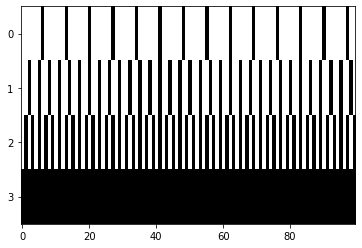

In [2]:
import torch
import norse.torch as snn

data = torch.tensor([2, 4, 8, 16])

encoder = snn.ConstantCurrentLIFEncoder(seq_length = 100) # Encode for 100 timesteps

snn.utils.plot_spikes_2d(encoder(data))

As expected, four input values gets mapped to four neurons (y-axis).
Neuron 0 receives a small input (2) and spikes a few times. Neuron 3 reveives the largest input (16) and seems to spike constantly!

## 2.2 Rate encoding using poisson codes

The idea is similar to the LIF encoder, but now with a stochastic element.
The code is almost the same:

<AxesSubplot:>

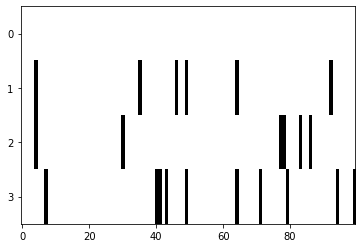

In [3]:
data = torch.tensor([0, 0.3, 0.6, 1.0])

encoder = snn.PoissonEncoder(seq_length = 100) # Encode for 100 timesteps

snn.utils.plot_spikes_2d(encoder(data))

Try to run the cell above: the stochastic nature of the poisson encoder makes the spike output quite unpredictable!

## 2.3 Spike latency encoding

We will yet again use the LIF equation to determine when the first spike will arrive.
Notice how, for each neuron, there are no subsequent spikes because the entire idea of the encoding mechanism is to rely on the timing of the *first* spike

<AxesSubplot:>

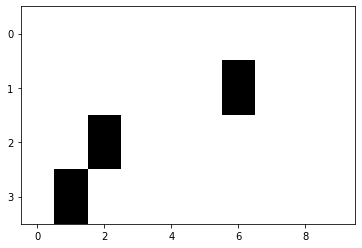

In [4]:
data = torch.tensor([1, 2, 4, 8])

encoder = snn.SpikeLatencyLIFEncoder(seq_length = 10) # Encode for 10 timesteps

snn.utils.plot_spikes_2d(encoder(data))

Notice also how the first neuron never spikes! That's because the neuron does not provide sufficient input to elicit a spike in the LIF equation.

## 2.4 Population encoding

Population encoding will automatically create $n$ neurons for every input number.
Each $n$ neuron will then be given a number, based on how *close* the neuron is to the receptive field.

<AxesSubplot:>

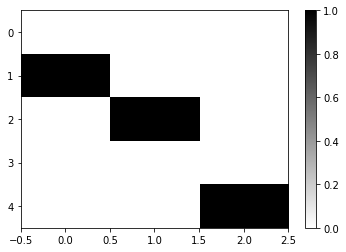

In [5]:
data = torch.tensor([2, 4, 8])

encoder = snn.PopulationEncoder(out_features = 5) # Use 5 neurons to encode for each input

snn.utils.plot_spikes_2d(encoder(data), show_colorbar=True)

Unfortunately, this still does not directly provide spikes.
Therefore, we need to still use some form of spike encoding to go to the spiking domain.

<AxesSubplot:>

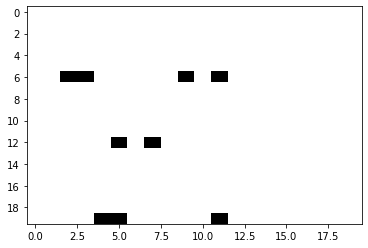

In [6]:
data = torch.tensor([1, 2, 4, 8])

encoder = torch.nn.Sequential(
    snn.PopulationEncoder(out_features = 5), # Use 5 neurons to encode for each input
    snn.PoissonEncoder(seq_length=20)         # Encode for 20 timesteps
)
snn.utils.plot_spikes_2d(encoder(data).view(20, -1))

# 3. Encoding MNIST data

We can test out these encoders on "real" data such as the beloved MNIST dataset.

In [7]:
import torchvision

dataset = torchvision.datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

example, label = dataset[7]

## 3.1 Visualizing MNIST

MNIST consists of black-and-white pictures of 28x28 pictures that looks like so:

<AxesSubplot:>

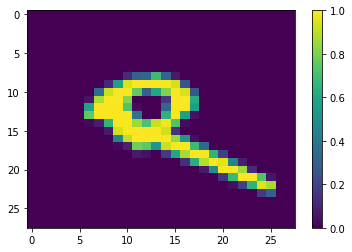

In [8]:
snn.utils.plot_heatmap_2d(example, show_colorbar=True)

## 3.2 Encoding MNIST digits

As we can see, the values are somewhere between 0 and 1.
We can take that directly and encode this with a `PoissonEncoder`, just like we saw above!

<AxesSubplot:>

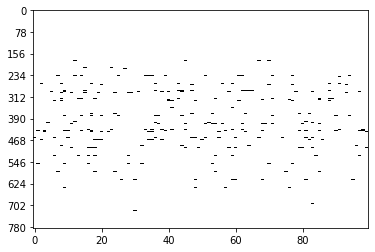

In [9]:
encoder = snn.PoissonEncoder(seq_length = 100)
snn.utils.plot_spikes_2d(encoder(example). view(100, -1))

This may look weird, but this shows how 28x28=784 neurons are encoded to produce spikes over 100 timesteps.
This is obviously quite wasteful, but as a sidenode the spike encoding is actually not that inefficient, considering that the spikes are binary and quite sparse.

```{note}
Try encoding different datasets than MNIST! There are many freely available datasets [on the PyTorch website](https://pytorch.org/docs/stable/torchvision/datasets.html).
```

## 4. Project Ideas

To summarize, we briefly glossed over different encoding types and demonstrated how you can apply encoding to MNIST digits. 
The same principle can apply to audio, video, text, etc.

Here are some project ideas:

- Design a task which uses a biologically plausible Audio to Spike conversion like
  [lauscher](https://github.com/electronicvisions/lauscher).
- What other data could be used as input to a Spiking Neural Network and how?
- [Event based cameras](https://en.wikipedia.org/wiki/Event_camera) produce sparse data, much like the spikes we have seen above. Tonic, a dataloader for neuromorphic datasets, has a lot of [event-based datasets to play with](https://tonic.readthedocs.io/en/latest/reference/datasets.html)